# Import Data

In [1]:
import os
import researchpy as rp
import pandas as pd
import pickle

import statsmodels.api as sm
from statsmodels.formula.api import ols

dir = os.scandir('data/')
experiments = list(filter(lambda x: x.name.endswith(".pickle"), dir))

df = pd.DataFrame()

for experiment in experiments:
    dffile = open(experiment.path, 'rb')      
    read_df = pickle.load(dffile)
    read_df = read_df[['max_epochs', 'executor_memory', 'executor_cores', 'model', 'accuracy', 'time']]
    df = pd.concat([df, read_df])


acc_df = pd.DataFrame({'y': df["accuracy"],
                       'epochs': df["max_epochs"],
                       'memory': df["executor_memory"],
                       'cores': df["executor_cores"],
                       'model': df["model"]})

time_df = pd.DataFrame({'y': df["time"],
                        'epochs': df["max_epochs"],
                        'memory': df["executor_memory"],
                        'cores': df["executor_cores"],
                        'model': df["model"]})

print(f"Imported {len(experiments)} experiments!")

Imported 10 experiments!


# Data Preparation

In [2]:
def df_to_x_and_y(data_df):
    output_column = "epochs"
    data_X = data_df[[x for x in data_df.columns if x != output_column]]
    data_y = data_df[[output_column]]
    data_y = data_y.to_numpy().flatten()
    return data_X, data_y

def numerize_model_names(df_data):
    numerized = df_data.copy()
    numerized['model'] = numerized['model'].apply(lambda x: -100 if x == "bi-rnn" else 100)
    return numerized

In [3]:
from imblearn import over_sampling
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, linear_model, svm, metrics, tree
from sklearn.metrics import mean_absolute_error, mean_squared_error, confusion_matrix
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt

acc_df_numerized_models = numerize_model_names(acc_df)
time_df_numerized_models = numerize_model_names(time_df)


# All Models

In [39]:
import numpy as np
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


def model_testing(input_df, learning_models, x_axis, plot_name_prefix, x_label):
    for model in learning_models:
        print(f"=========   {plot_name_prefix}: {model}   ==========")
        absolute_errors = []
        squared_errors = []

        feature_vectors, labels = df_to_x_and_y(input_df)

        for i in range(0, 10):
            x_train, x_test, y_train, y_test = train_test_split(feature_vectors,
                                                                labels,
                                                                train_size=int(.80 * len(input_df)),
                                                                test_size=int(.20 * len(input_df)))

            trained_model = model.fit(x_train, y_train)
            predictions = trained_model.predict(x_test)
            absolute_errors.append(mean_absolute_error(y_test, predictions))
            squared_errors.append(mean_squared_error(y_test, predictions))

        print(f'Mean absolute error: {np.mean(np.array(absolute_errors))}')
        print(f'Mean squared error: {np.mean(np.array(squared_errors))}')

        for learning_model in [-1, 1]:
            for cores in [8, 16]:
                for memory in [4, 32]:
                    input_data = [[i, memory, cores, learning_model] for i in x_axis]
                    predictions = trained_model.predict(input_data)
                    learning_model_name = "le" if learning_model == 1 else "br"
                    plt.plot(x_axis, predictions, label=f"{learning_model_name} C:{cores} M:{memory}")

        plt.scatter(input_df["y"], input_df["epochs"])
        plt.legend()
        plt.plot(x_axis, predictions)
        plt.title(model)
        plt.ylim(0, 100)
        plt.ylabel("Epochs")
        plt.xlabel(x_label)
        plt.show()   

## Time model results

=========   Time: SVR()   ==========
Mean absolute error: 9.776511580296695
Mean squared error: 129.04432937068435


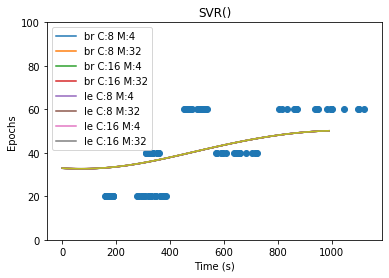

=========   Time: LinearRegression()   ==========
Mean absolute error: 5.290678078562648
Mean squared error: 44.16513796047285


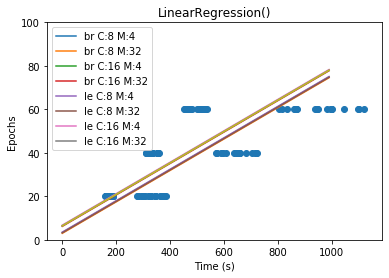

=========   Time: LinearDiscriminantAnalysis()   ==========
Mean absolute error: 0.6666666666666667
Mean squared error: 13.333333333333334


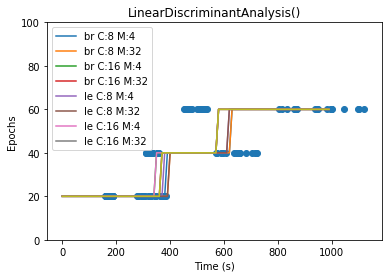

In [40]:

time_learning_models = [
                        SVR(),
#                         tree.DecisionTreeRegressor(),
#                         MLPRegressor(),
#                         linear_model.SGDRegressor(),
#                         linear_model.BayesianRidge(),
#                         linear_model.LassoLars(),
#                         linear_model.ARDRegression(),
#                         linear_model.PassiveAggressiveRegressor(),
#                         linear_model.TheilSenRegressor(),
                        linear_model.LinearRegression(),
                        LinearDiscriminantAnalysis(),
#                         QuadraticDiscriminantAnalysis()
                       ]

model_testing(time_df_numerized_models, time_learning_models, [i * 10 for i in range(100)], "Time", "Time (s)")

## Accuracy model results

=========   Accuracy: DecisionTreeRegressor()   ==========
Mean absolute error: 2.0
Mean squared error: 39.16666666666667


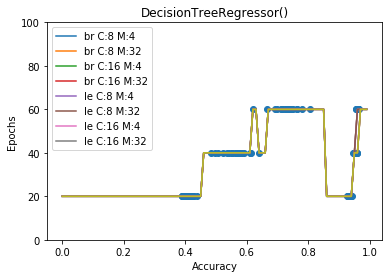

=========   Accuracy: LinearRegression()   ==========
Mean absolute error: 8.237353566080847
Mean squared error: 133.30411767425718


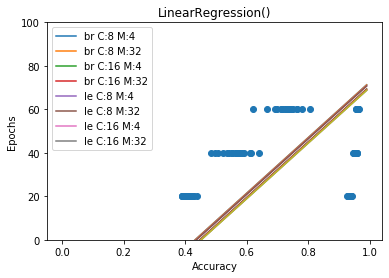

=========   Accuracy: LinearDiscriminantAnalysis()   ==========
Mean absolute error: 7.583333333333334
Mean squared error: 151.66666666666669


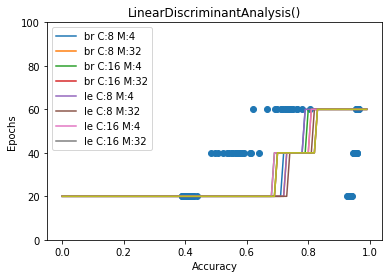

In [41]:

acc_learning_models = [
#                        SVR(),
                       tree.DecisionTreeRegressor(),
#                        MLPRegressor(),
#                        linear_model.SGDRegressor(),
#                        linear_model.BayesianRidge(),
#                        linear_model.LassoLars(),
#                        linear_model.ARDRegression(),
#                        linear_model.PassiveAggressiveRegressor(),
#                        linear_model.TheilSenRegressor(),
                       linear_model.LinearRegression(),
                       LinearDiscriminantAnalysis(),
#                        QuadraticDiscriminantAnalysis()
                      ]

model_testing(acc_df_numerized_models, acc_learning_models, [i / 100 for i in range(100)], "Accuracy", "Accuracy")